In [ ]:
import torch
import pandas as pd
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm.auto import tqdm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os

print("Starting fast activation patching experiment...")

# Configuration
MODEL_NAME = "meta-llama/Llama-2-13b-chat-hf"
HF_TOKEN = {your_token}
CSV_PATH = "prompts_response_classification.csv"
DATASET_SIZE = 40
MAX_LENGTH = 256  # Shorter for speed
DEVICE = "cuda"

torch.set_grad_enabled(False)

# Load model with optimizations
print("Loading model...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, token=HF_TOKEN)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, 
    token=HF_TOKEN,
    torch_dtype=torch.bfloat16,
    device_map="cuda:0"  # Force single GPU
)

print("Model loaded successfully")

Starting fast activation patching experiment...
Loading model...


Loading checkpoint shards: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

Model loaded successfully


In [3]:
# Load and prepare data
df = pd.read_csv(CSV_PATH)
certain_prompts = df[df["epistemic_status"] == "certain"]["prompt"].dropna().tolist()[:DATASET_SIZE]
uncertain_prompts = df[df["epistemic_status"] == "uncertain"]["prompt"].dropna().tolist()[:DATASET_SIZE]

print(f"Dataset: {len(certain_prompts)} certain, {len(uncertain_prompts)} uncertain prompts")

# Get metric tokens
certain_token_id = tokenizer.encode(" is", add_special_tokens=False)[-1]
uncertain_token_id = tokenizer.encode(" might", add_special_tokens=False)[-1]

Dataset: 40 certain, 40 uncertain prompts


In [4]:
def get_logit_diff(logits, attention_mask):
    """Fast logit difference calculation"""
    seq_lens = attention_mask.sum(dim=1) - 1
    final_logits = logits[torch.arange(logits.shape[0], device=logits.device), seq_lens]
    return final_logits[:, certain_token_id] - final_logits[:, uncertain_token_id]

In [5]:
def run_patching_experiment(clean_prompts, corrupted_prompts, exp_name):
    """Unified patching function for both experiments"""
    
    print(f"\nRunning {exp_name}...")
    
    # Tokenize
    clean_tokens = tokenizer(clean_prompts, return_tensors="pt", padding=True, 
                           truncation=True, max_length=MAX_LENGTH).to(DEVICE)
    corrupted_tokens = tokenizer(corrupted_prompts, return_tensors="pt", padding=True,
                                truncation=True, max_length=MAX_LENGTH).to(DEVICE)
    
    # Get baselines
    with torch.no_grad():
        clean_logits = model(**clean_tokens).logits
        corrupted_logits = model(**corrupted_tokens).logits
    
    clean_baseline = get_logit_diff(clean_logits, clean_tokens.attention_mask).mean().item()
    corrupted_baseline = get_logit_diff(corrupted_logits, corrupted_tokens.attention_mask).mean().item()
    
    print(f"Clean baseline: {clean_baseline:.3f}, Corrupted baseline: {corrupted_baseline:.3f}")
    
    # Clear memory
    del clean_logits, corrupted_logits
    torch.cuda.empty_cache()
    
    # Patching results
    results = torch.zeros(model.config.num_hidden_layers, device=DEVICE)
    
    for layer_idx in tqdm(range(model.config.num_hidden_layers), desc=f"{exp_name}"):
        
        # Get clean activation for this layer
        clean_activation = None
        def save_clean(module, input, output):
            nonlocal clean_activation
            clean_activation = input[0].clone()
        
        hook = model.model.layers[layer_idx].register_forward_hook(save_clean)
        with torch.no_grad():
            model(**clean_tokens)
        hook.remove()
        
        # Patch and test
        def patch_layer(module, input):
            corrupted_resid = input[0]
            
            # Get sequence positions
            clean_seq_lens = clean_tokens.attention_mask.sum(dim=1) - 1
            corrupted_seq_lens = corrupted_tokens.attention_mask.sum(dim=1) - 1
            batch_indices = torch.arange(corrupted_resid.shape[0], device=corrupted_resid.device)
            
            # Apply patch
            patched_resid = corrupted_resid.clone()
            patched_resid[batch_indices, corrupted_seq_lens] = clean_activation[batch_indices, clean_seq_lens]
            
            return (patched_resid,)
        
        hook = model.model.layers[layer_idx].register_forward_pre_hook(patch_layer)
        
        with torch.no_grad():
            patched_logits = model(**corrupted_tokens).logits
        
        hook.remove()
        
        # Calculate effect
        patched_score = get_logit_diff(patched_logits, corrupted_tokens.attention_mask).mean().item()
        results[layer_idx] = patched_score
        
        # Cleanup
        del clean_activation, patched_logits
        torch.cuda.empty_cache()
    
    # Normalize
    normalized = (results - corrupted_baseline) / (clean_baseline - corrupted_baseline)
    return normalized.cpu()

In [8]:
# Run both experiments
print("Starting experiments...")

# Experiment 2A: Certainty restoration
results_2a = run_patching_experiment(certain_prompts, uncertain_prompts, "2A: Certainty")

Starting experiments...

Running 2A: Certainty...
Clean baseline: 4.031, Corrupted baseline: 3.859


2A: Certainty: 100%|██████████| 40/40 [00:13<00:00,  3.01it/s]


In [9]:
# Experiment 2B: Uncertainty transfer  
results_2b = run_patching_experiment(uncertain_prompts, certain_prompts, "2B: Uncertainty")


Running 2B: Uncertainty...
Clean baseline: 3.859, Corrupted baseline: 4.031


2B: Uncertainty: 100%|██████████| 40/40 [00:13<00:00,  3.01it/s]


Creating visualization with matplotlib...


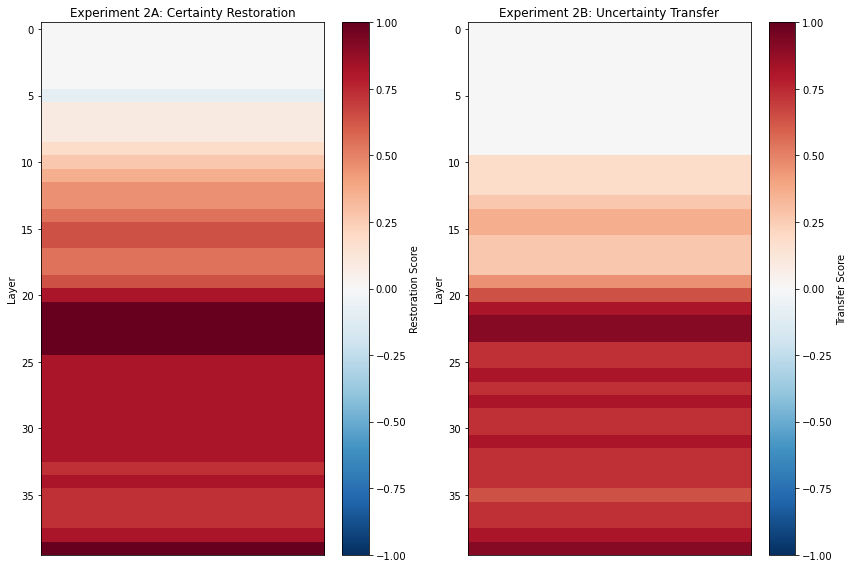

Visualization displayed above


In [15]:
# Simple matplotlib visualization for notebook display
print("Creating visualization with matplotlib...")

import matplotlib.pyplot as plt

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

# Plot 2A
im1 = ax1.imshow(results_2a.numpy().reshape(-1, 1), cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
ax1.set_title('Experiment 2A: Certainty Restoration')
ax1.set_ylabel('Layer')
ax1.set_yticks(range(0, len(results_2a), 5))
ax1.set_yticklabels(range(0, len(results_2a), 5))
ax1.set_xticks([])

# Plot 2B
im2 = ax2.imshow(results_2b.numpy().reshape(-1, 1), cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
ax2.set_title('Experiment 2B: Uncertainty Transfer')
ax2.set_ylabel('Layer')
ax2.set_yticks(range(0, len(results_2b), 5))
ax2.set_yticklabels(range(0, len(results_2b), 5))
ax2.set_xticks([])

# Add colorbars
plt.colorbar(im1, ax=ax1, label='Restoration Score')
plt.colorbar(im2, ax=ax2, label='Transfer Score')

plt.tight_layout()
plt.show()

print("Visualization displayed above")

In [16]:
# Print summary
print("\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)

top_2a = results_2a.topk(5)
top_2b = results_2b.topk(5)

print("Top 5 Certainty Restoration Layers:")
for i, (score, layer) in enumerate(zip(top_2a.values, top_2a.indices)):
    print(f"  {i+1}. Layer {layer.item():2d}: {score.item():.3f}")

print("\nTop 5 Uncertainty Transfer Layers:")
for i, (score, layer) in enumerate(zip(top_2b.values, top_2b.indices)):
    print(f"  {i+1}. Layer {layer.item():2d}: {score.item():.3f}")

print(f"\nOverall Performance:")
print(f"  Mean certainty restoration: {results_2a.mean().item():.3f}")
print(f"  Mean uncertainty transfer: {results_2b.mean().item():.3f}")
print(f"  Circuit strength ratio: {results_2a.mean().item() / results_2b.mean().item():.2f}x")

# Find high-impact layers
high_2a = (results_2a > 0.5).nonzero(as_tuple=True)[0]
high_2b = (results_2b > 0.5).nonzero(as_tuple=True)[0]
overlap = set(high_2a.tolist()) & set(high_2b.tolist())

print(f"\nHigh-Impact Layer Analysis:")
print(f"  Certainty layers (>0.5): {len(high_2a)}")
print(f"  Uncertainty layers (>0.5): {len(high_2b)}")
print(f"  Overlapping layers: {len(overlap)}")

if overlap:
    print(f"  Shared layers: {sorted(list(overlap))}")

print(f"\nResults saved to: circuit_discovery_results.png")
print("Experiment complete!")


RESULTS SUMMARY
Top 5 Certainty Restoration Layers:
  1. Layer 22: 1.000
  2. Layer 24: 1.000
  3. Layer 23: 1.000
  4. Layer 39: 1.000
  5. Layer 21: 1.000

Top 5 Uncertainty Transfer Layers:
  1. Layer 39: 0.909
  2. Layer 23: 0.909
  3. Layer 22: 0.909
  4. Layer 26: 0.818
  5. Layer 31: 0.818

Overall Performance:
  Mean certainty restoration: 0.559
  Mean uncertainty transfer: 0.455
  Circuit strength ratio: 1.23x

High-Impact Layer Analysis:
  Certainty layers (>0.5): 26
  Uncertainty layers (>0.5): 20
  Overlapping layers: 20
  Shared layers: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]

Results saved to: circuit_discovery_results.png
Experiment complete!
